In [78]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import norm

def estimates(ticker, strike, vol, enddata, expiration):


    # Function to calculate Black-Scholes Greeks
    def black_scholes_greeks(S, K, T, r, sigma):
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        delta = norm.cdf(d1)
        gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
        theta = -(S * norm.pdf(d1) * sigma) / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * norm.cdf(d1)
        return call_price, delta, gamma, theta

    # Fetch historical stock prices for AAPL
    stock_data = yf.download(ticker, start='2023-01-01', end=enddata)

    stock_data.info()
    # Extract the 'Close' prices and convert index to datetime
    stock_prices = stock_data['Close']
    stock_volu = stock_data['Volume']
    stock_prices.index = pd.to_datetime(stock_prices.index)

    # Define option parameters
    K = strike  # Strike price of the option
    r = 0.01  # Risk-free interest rate
    sigma = vol # Volatility of the underlying stock

    # Initialize lists to store values
    option_prices = []
    delta_values = []
    gamma_values = []
    theta_values = []

    for date in stock_prices.index:
        # Calculate time to expiration dynamically
        T = (pd.Timestamp(expiration) - date).days / 365

        # Get the corresponding stock price
        S = stock_prices.loc[date]

        # Calculate option price and Greeks
        call_price, delta, gamma, theta = black_scholes_greeks(S, K, T, r, sigma)

        # Append to lists
        option_prices.append(call_price)
        delta_values.append(delta)
        gamma_values.append(gamma)
        theta_values.append(theta)

    # Plot stock prices, option price, and Greeks on the same time axis
    plt.figure(figsize=(10, 6))
    plt.plot(stock_prices.index, stock_prices.values, label='Stock Price', color='black')
    plt.plot(stock_prices.index, option_prices, label='Call Option Price', color='blue')
    plt.title(ticker+' Stock Price, Call Option Price')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(stock_prices.index, delta_values, label='Delta', color='red')
    plt.plot(stock_prices.index, gamma_values, label='Gamma', color='green')
    #plt.plot(stock_prices.index, theta_values, label='Theta', color='orange')

    plt.title('Option Greeks')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()


    stock_data['Volume'] = stock_data['Volume'] / 1000000
    stock_data.describe().T

    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error

    maturity_date = pd.Timestamp(expiration)


    opp = pd.DataFrame({'OPrice': option_prices})
    delt = pd.DataFrame({'Delta': delta_values})
    gam = pd.DataFrame({'Gamma': gamma_values})
    thet = pd.DataFrame({'Theta': theta_values})


    df = pd.concat([ opp, delt, gam, thet], axis=1)
    df.set_index(stock_data.index, inplace=True)
    df['volu']=stock_data['Volume']
    df['precio']=stock_data['Close']
    df['time_to_maturity'] = (maturity_date - df.index).days / 365


    df['lggamma'] = df['Gamma'].shift(1)
    df['lgdelta'] = df['Delta'].shift(1)
    df['lgprice'] = df['OPrice'].shift(1)
    df['lgtheta'] = df['Theta'].shift(1)
    df['lgvolu'] = df['volu'].shift(1)
    df['lgprix'] = df['precio'].shift(1)

    df['lggamma2'] = df['Gamma'].shift(2)
    df['lgdelta2'] = df['Delta'].shift(2)
    df['lgprice2'] = df['OPrice'].shift(2)
    df['lgtheta2'] = df['Theta'].shift(2)
    df['lgvolu2'] = df['volu'].shift(2)
    df['lgprix2'] = df['precio'].shift(2)

    #y = df['Gamma']
    #df['invlagt'] = 1 / df['time_to_maturity']
    #df['invlagp'] = 1 / df['lgprice']
    #df['interac'] = df['invlagp']*df['invlagt']
    #df.to_excel('output5.xlsx', index=True)
    #df = df.drop(df.columns[:12], axis=1)
        
    df['lngamma'] = np.log(df['Gamma'])
    

   
    
    df['lnlggamma'] = np.log(df['lggamma'])
    df['lnlgvolu'] = np.log(df['lgvolu'])
    df['lnlggamma2'] = np.log(df['lggamma2'])
    df['lnlgvolu2'] = np.log(df['lgvolu2'])

    
        
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import r2_score
    import statsmodels.api as sm



    df = df.dropna()
    df['lnt'] = np.log(df['time_to_maturity'])
    X = df[['lnlggamma', 'lnt', 'lgprice', 'lgprix', 'lgdelta', 'lgtheta', 'lgprix2']]
    y = df['lngamma']
    df.to_excel('output10.xlsx', index=True)

    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    n = len(X)
    split_index = int(n * 0.9)
    X_train = X.iloc[:split_index]
    y_train = y.iloc[:split_index]
    X_test = X.iloc[split_index:]
    y_test = y.iloc[split_index:]

    

    # Function to fit a model and return AIC, BIC, and R²
    def fit_model_and_evaluate(X_train, y_train, X_test, y_test):
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)

        X_train_sm = sm.add_constant(X_train)  # Adds a constant term to the predictor
        model_sm = sm.OLS(y_train, X_train_sm).fit()
        aic = model_sm.aic
        bic = model_sm.bic
        return aic, bic, r2

    # Initial model with all features
    initial_aic, initial_bic, initial_r2 = fit_model_and_evaluate(X_train, y_train, X_test, y_test)
    #print(f'Initial model AIC: {initial_aic}, BIC: {initial_bic}, R²: {initial_r2}')

    # Evaluate models by removing one feature at a time
    results = []
    for feature in X.columns:
        X_train_reduced = X_train.drop(columns=[feature])
        X_test_reduced = X_test.drop(columns=[feature])
        aic, bic, r2 = fit_model_and_evaluate(X_train_reduced, y_train, X_test_reduced, y_test)
        results.append((feature, aic, bic, r2))

    # Find the best model based on AIC, BIC, and R²
    best_aic = min(results, key=lambda x: x[1])
    best_bic = min(results, key=lambda x: x[2])
    best_r2 = max(results, key=lambda x: x[3])

    #print("\nBest model results after removing one feature:")
    #print(f"Best AIC: Remove {best_aic[0]}, AIC: {best_aic[1]}, BIC: {best_aic[2]}, R²: {best_aic[3]}")
    #print(f"Best BIC: Remove {best_bic[0]}, AIC: {best_bic[1]}, BIC: {best_bic[2]}, R²: {best_bic[3]}")
    #print(f"Best R²: Remove {best_r2[0]}, AIC: {best_r2[1]}, BIC: {best_r2[2]}, R²: {best_r2[3]}")

    #X = X.drop(columns=['lgdelta'])
    
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X = X.drop(columns=['lgprice'])
    X_train = X_train.drop(columns=['lgprice'])
    X_test = X_test.drop(columns=['lgprice'])
    

    # Function to fit a model and return AIC, BIC, and R²
    def fit_model_and_evaluate(X_train, y_train, X_test, y_test):
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)

        X_train_sm = sm.add_constant(X_train)  # Adds a constant term to the predictor
        model_sm = sm.OLS(y_train, X_train_sm).fit()
        aic = model_sm.aic
        bic = model_sm.bic
        return aic, bic, r2

    # Initial model with all features
    initial_aic, initial_bic, initial_r2 = fit_model_and_evaluate(X_train, y_train, X_test, y_test)
    #print(f'Initial model AIC: {initial_aic}, BIC: {initial_bic}, R²: {initial_r2}')

    # Evaluate models by removing one feature at a time
    results = []
    for feature in X.columns:
        X_train_reduced = X_train.drop(columns=[feature])
        X_test_reduced = X_test.drop(columns=[feature])
        aic, bic, r2 = fit_model_and_evaluate(X_train_reduced, y_train, X_test_reduced, y_test)
        results.append((feature, aic, bic, r2))

    # Find the best model based on AIC, BIC, and R²
    best_aic = min(results, key=lambda x: x[1])
    best_bic = min(results, key=lambda x: x[2])
    best_r2 = max(results, key=lambda x: x[3])

    #print("\nBest model results after removing one feature:")
    #print(f"Best AIC: Remove {best_aic[0]}, AIC: {best_aic[1]}, BIC: {best_aic[2]}, R²: {best_aic[3]}")
    #print(f"Best BIC: Remove {best_bic[0]}, AIC: {best_bic[1]}, BIC: {best_bic[2]}, R²: {best_bic[3]}")
    #print(f"Best R²: Remove {best_r2[0]}, AIC: {best_r2[1]}, BIC: {best_r2[2]}, R²: {best_r2[3]}")

    #print(X)
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X = X.drop(columns=['lgprix2'])
    X_train = X_train.drop(columns=['lgprix2'])
    X_test = X_test.drop(columns=['lgprix2'])
    

    # Function to fit a model and return AIC, BIC, and R²
    def fit_model_and_evaluate(X_train, y_train, X_test, y_test):
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)

        X_train_sm = sm.add_constant(X_train)  # Adds a constant term to the predictor
        model_sm = sm.OLS(y_train, X_train_sm).fit()
        aic = model_sm.aic
        bic = model_sm.bic
        return aic, bic, r2

    # Initial model with all features
    initial_aic, initial_bic, initial_r2 = fit_model_and_evaluate(X_train, y_train, X_test, y_test)
    #print(f'Initial model AIC: {initial_aic}, BIC: {initial_bic}, R²: {initial_r2}')

    # Evaluate models by removing one feature at a time
    results = []
    for feature in X.columns:
        X_train_reduced = X_train.drop(columns=[feature])
        X_test_reduced = X_test.drop(columns=[feature])
        aic, bic, r2 = fit_model_and_evaluate(X_train_reduced, y_train, X_test_reduced, y_test)
        results.append((feature, aic, bic, r2))

    # Find the best model based on AIC, BIC, and R²
    best_aic = min(results, key=lambda x: x[1])
    best_bic = min(results, key=lambda x: x[2])
    best_r2 = max(results, key=lambda x: x[3])

    #print("\nBest model results after removing one feature:")
    #print(f"Best AIC: Remove {best_aic[0]}, AIC: {best_aic[1]}, BIC: {best_aic[2]}, R²: {best_aic[3]}")
    #print(f"Best BIC: Remove {best_bic[0]}, AIC: {best_bic[1]}, BIC: {best_bic[2]}, R²: {best_bic[3]}")
    #print(f"Best R²: Remove {best_r2[0]}, AIC: {best_r2[1]}, BIC: {best_r2[2]}, R²: {best_r2[3]}")

    #X = X.drop(columns=['lgprice'])
#print(X)
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X = X.drop(columns=['lgdelta'])
    X_train = X_train.drop(columns=['lgdelta'])
    X_test = X_test.drop(columns=['lgdelta'])
    

    # Function to fit a model and return AIC, BIC, and R²
    def fit_model_and_evaluate(X_train, y_train, X_test, y_test):
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)

        X_train_sm = sm.add_constant(X_train)  # Adds a constant term to the predictor
        model_sm = sm.OLS(y_train, X_train_sm).fit()
        aic = model_sm.aic
        bic = model_sm.bic
        return aic, bic, r2

    # Initial model with all features
    initial_aic, initial_bic, initial_r2 = fit_model_and_evaluate(X_train, y_train, X_test, y_test)
    #print(f'Initial model AIC: {initial_aic}, BIC: {initial_bic}, R²: {initial_r2}')

    # Evaluate models by removing one feature at a time
    results = []
    for feature in X.columns:
        X_train_reduced = X_train.drop(columns=[feature])
        X_test_reduced = X_test.drop(columns=[feature])
        aic, bic, r2 = fit_model_and_evaluate(X_train_reduced, y_train, X_test_reduced, y_test)
        results.append((feature, aic, bic, r2))

    # Find the best model based on AIC, BIC, and R²
    best_aic = min(results, key=lambda x: x[1])
    best_bic = min(results, key=lambda x: x[2])
    best_r2 = max(results, key=lambda x: x[3])

    
    X = X.drop(columns=['lgprix'])
    X_train = X_train.drop(columns=['lgprix'])
    X_test = X_test.drop(columns=['lgprix'])
    

    # Function to fit a model and return AIC, BIC, and R²
    def fit_model_and_evaluate(X_train, y_train, X_test, y_test, showpvalues):
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        fitted_values = model.predict(X_train)
        r2 = r2_score(y_test, y_pred)

        X_train_sm = sm.add_constant(X_train)  # Adds a constant term to the predictor
        model_sm = sm.OLS(y_train, X_train_sm).fit()
        aic = model_sm.aic
        bic = model_sm.bic
        sigma_hat = np.sqrt(model_sm.mse_resid)
        #print("SIGMA HAT = ", sigma_hat)  
        residuals = y_test - y_pred
        residualstrain = y_train - fitted_values
        if showpvalues:
            pvalues = model_sm.pvalues
            print(pvalues)
            plt.figure(figsize=(12, 8))
            for i, feature in enumerate(X_train.columns):
                plt.subplot(2, 2, i+1)
                plt.scatter(X_train[feature], residualstrain)
                plt.axhline(y=0, color='r', linestyle='--')
                plt.xlabel(feature)
                plt.ylabel('Residuals')
                plt.title(f'Residuals vs {feature}')
                plt.tight_layout(pad=3.0)
            plt.figure(figsize=(11, 7))
            plt.scatter(fitted_values, residualstrain)
            plt.xlabel('Fitted values')
            plt.ylabel('Residuals')
            plt.title(f'Residuals vs fitted values')
    
        coefs = list()
        coefs.append(model.intercept_)
        #print(model.intercept_)    
        #print("Regression Coefficients:")
        for feature, coef in zip(X_train.columns, model.coef_):
            #print(f"{feature}: {coef}")
            coefs.append(coef)



        return aic, bic, r2, coefs, sigma_hat

    # Initial model with all features
    initial_aic, initial_bic, initial_r2, coefs, sigma_hat = fit_model_and_evaluate(X_train, y_train, X_test, y_test, False)
    #print(f'Initial model AIC: {initial_aic}, BIC: {initial_bic}, R²: {initial_r2}')

    # Evaluate models by removing one feature at a time
    results = []
    for feature in X.columns:
        X_train_reduced = X_train.drop(columns=[feature])
        X_test_reduced = X_test.drop(columns=[feature])
        aic, bic, r2, _ , _ = fit_model_and_evaluate(X_train_reduced, y_train, X_test_reduced, y_test, False)
        results.append((feature, aic, bic, r2))

    # Find the best model based on AIC, BIC, and R²
    best_aic = min(results, key=lambda x: x[1])
    best_bic = min(results, key=lambda x: x[2])
    best_r2 = max(results, key=lambda x: x[3])

    #print("\nBest model results after removing one feature:")
    #print(f"Best AIC: Remove {best_aic[0]}, AIC: {best_aic[1]}, BIC: {best_aic[2]}, R²: {best_aic[3]}")
    #print(f"Best BIC: Remove {best_bic[0]}, AIC: {best_bic[1]}, BIC: {best_bic[2]}, R²: {best_bic[3]}")
    #print(f"Best R²: Remove {best_r2[0]}, AIC: {best_r2[1]}, BIC: {best_r2[2]}, R²: {best_r2[3]}")
    
    

    return coefs, sigma_hat, df.iloc[-1]

Suppose today is 15th May 2024 and you are given an AAPL call option with strike 185$ and maturity 26th May 2024. You want to delta-gamma hedge for a week so until 23rd May 2024. You need to hedge your call with another call option from another stock and find good estimates of the next days' Greeks.

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 344 entries, 2023-01-03 to 2024-05-15
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       344 non-null    float64
 1   High       344 non-null    float64
 2   Low        344 non-null    float64
 3   Close      344 non-null    float64
 4   Adj Close  344 non-null    float64
 5   Volume     344 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 18.8 KB


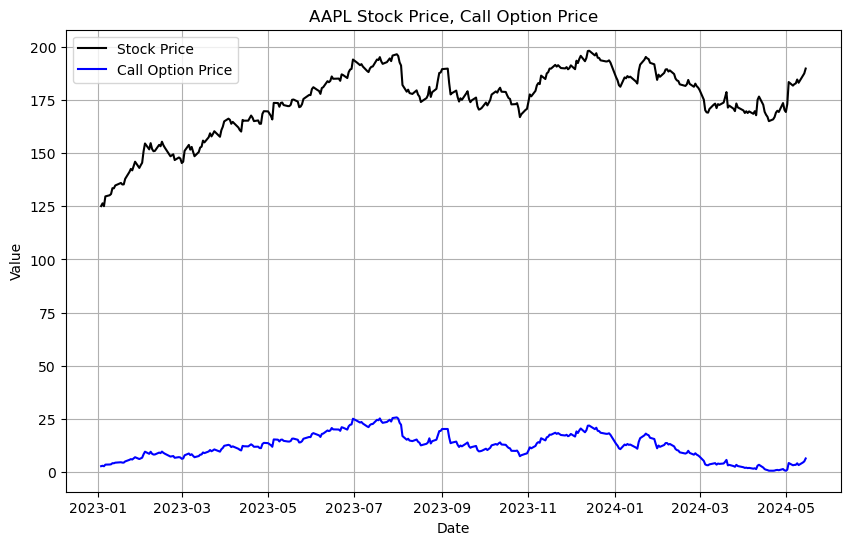

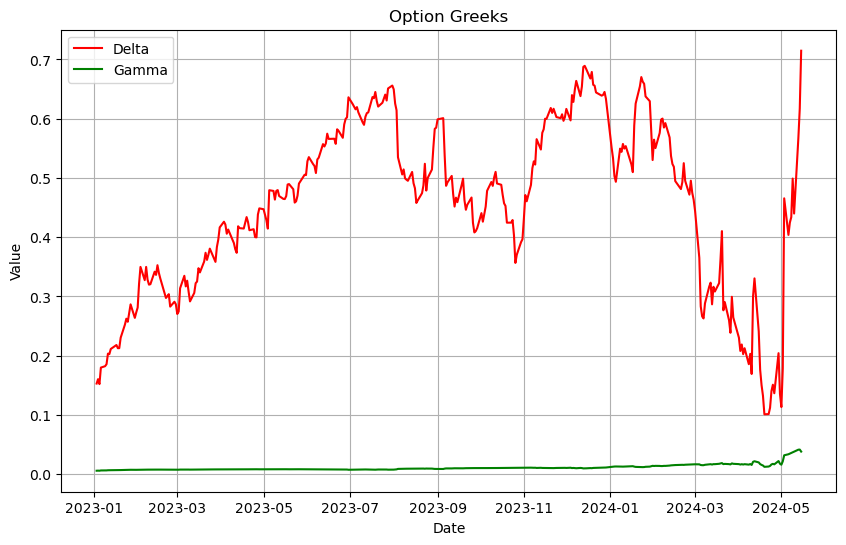

[*********************100%%**********************]  1 of 1 completed

Initial model AIC: -1535.7057363990057, BIC: -1509.6178021658952, R²: 0.8611097100264828
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 344 entries, 2023-01-03 to 2024-05-15
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       344 non-null    float64
 1   High       344 non-null    float64
 2   Low        344 non-null    float64
 3   Close      344 non-null    float64
 4   Adj Close  344 non-null    float64
 5   Volume     344 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 18.8 KB


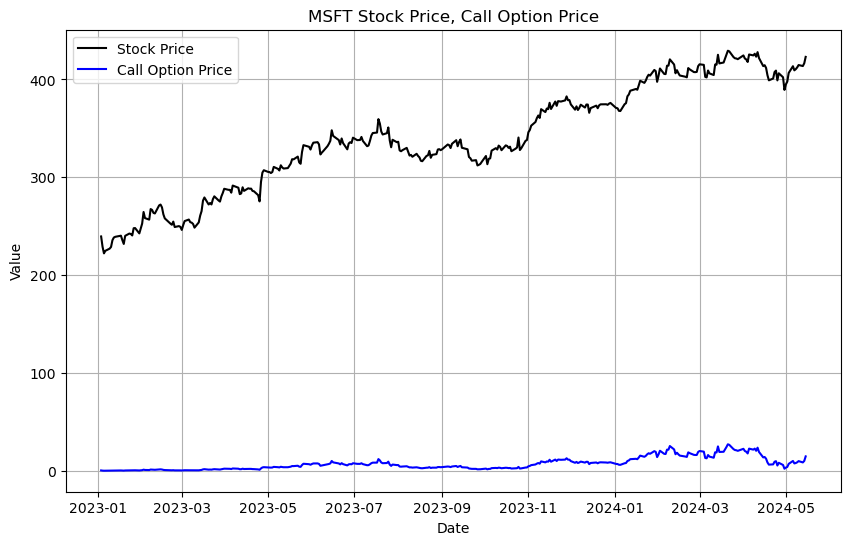

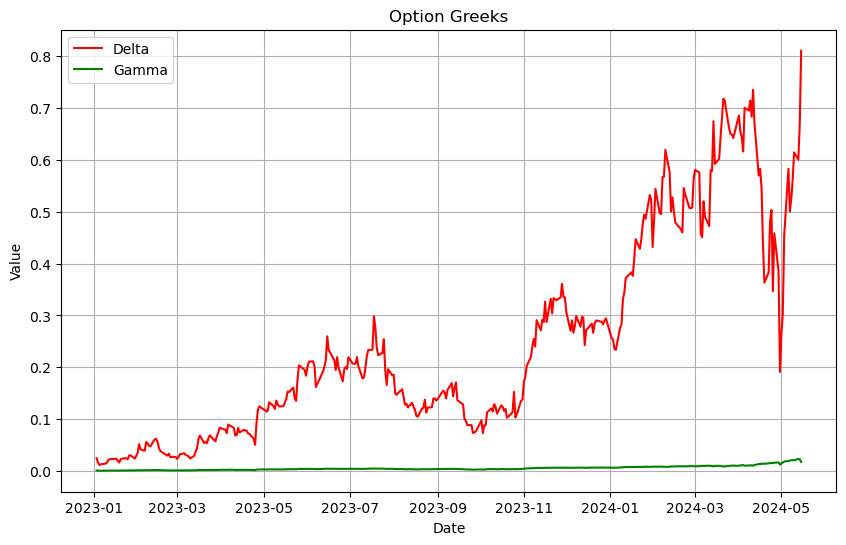

Initial model AIC: -706.5834271586159, BIC: -680.4954929255056, R²: 0.8182059314275913
0.03708631258373398 0.038173086076754084 0.018531962625719704 0.01739957627269382


In [79]:
coefs, sigma_hat, lastday = estimates('AAPL', 185, 0.2702, '2024-05-16', '2024-05-26')

import math

maturity_date = pd.Timestamp('2024-05-26')
time = (maturity_date - pd.Timestamp('2024-05-16')).days / 365
lgtime=math.log(time)

x_aapl = coefs[0]+coefs[1]*lastday['lngamma']+coefs[2]*lgtime+coefs[3]*lastday['Theta']
gamma_aapl_pred=math.exp(x_aapl)*math.exp(sigma_hat*sigma_hat/2)
gamma_aapl_prev = lastday['Gamma']
delta_aapl_prev = lastday['Delta']

coefs, sigma_hat, lastday = estimates('MSFT', 410, 0.2119, '2024-05-16', '2024-05-26')

x_msft = coefs[0]+coefs[1]*lastday['lngamma']+coefs[2]*lgtime+coefs[3]*lastday['Theta']
gamma_msft_pred=math.exp(x_msft)*math.exp(sigma_hat*sigma_hat/2)
gamma_msft_prev = lastday['Gamma']
delta_msft_prev = lastday['Delta']

print(gamma_aapl_pred, gamma_aapl_prev, gamma_msft_pred, gamma_msft_prev)




In [80]:
stock_data = yf.download('AAPL', start='2024-05-15', end='2024-05-16')
S= stock_data['Close']

def speed(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    speed = - ( norm.pdf(d1)) / (S**2 * sigma * np.sqrt(T)) * (d1 / (sigma * np.sqrt(T)) + 1)
    
    return speed

speed_aapl = speed(S, 185, (pd.Timestamp('2024-05-26') - pd.Timestamp('2024-05-15')).days / 365, 0.01, 0.2702)
stock_data = yf.download('MSFT', start='2024-05-15', end='2024-05-16')
S= stock_data['Close']
speed_msft = speed(S, 410, (pd.Timestamp('2024-05-26') - pd.Timestamp('2024-05-15')).days / 365, 0.01, 0.2119)

delta_aapl_pred= delta_aapl_prev+ gamma_aapl_pred * (gamma_aapl_pred - gamma_aapl_prev) / speed_aapl
delta_msft_pred= delta_msft_prev+ gamma_msft_pred * (gamma_msft_pred - gamma_msft_prev) / speed_msft
delta_aapl_pred=delta_aapl_pred.iloc[0]
delta_msft_pred=delta_msft_pred.iloc[0]


print(delta_aapl_pred,delta_aapl_prev , delta_msft_pred, delta_msft_prev)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

0.7299404862425491 0.7146345918275282 0.7901796344605722 0.8106477319642702


We know have all the predicted greeks we need, the final step is to delta-gamma hedge ! We just need to solve the two linear equations of delta-gamma hedging:

In [81]:
a1, b1, c1 = 1, delta_msft_pred, -delta_aapl_pred
a2, b2, c2 = 0, gamma_msft_pred, -gamma_aapl_pred

A = np.array([[a1, b1], [a2, b2]])
b = np.array([c1, c2])

positions = np.linalg.solve(A, b)

stock_position, msft_position = positions

print(f"Tomorrow you should hold: {stock_position*100} shares of stocks and {msft_position*100} MSFT call options")


Tomorrow you should hold: 85.1373350438435 shares of stocks and -200.12080389296437 MSFT call options
